## MKL Example 

In [1]:
import os
from torch_geometric.datasets import TUDataset
import os.path as osp
from torch_geometric.loader import DenseDataLoader
from torch_geometric.nn import DenseSAGEConv, dense_diff_pool,dense_mincut_pool
import torch_geometric.transforms as T
from sklearn.model_selection import KFold

import sys
sys.path.append("/home/rohit/PhD_Work/GM_my_version/Graph_matching/")
from sklearn.cluster import KMeans
import networkx as nx
import numpy as np
from graph_generation.load_graphs_and_create_metadata import dataset_metadata
from graph_matching_tools.metrics import matching
import matplotlib.pyplot as plt
import scipy.io as sco
import slam.io as sio
from scipy.special import softmax
import pickle
from scipy.stats import betabinom
import seaborn as sns
import tools.graph_processing as gp
import tools.graph_visu as gv
from matplotlib.pyplot import figure
import pandas as pd
import random
from torch_geometric.utils.convert import from_networkx
import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch.nn.functional import one_hot
from sklearn.preprocessing import OneHotEncoder
from torch.nn import Linear
import torch.nn.functional as F
from math import ceil
import torch_geometric as pyg
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import TopKPooling
from torch_geometric.data import Data
from torch_geometric.loader import DenseDataLoader
from torch.nn.utils.rnn import pad_sequence
from torch_geometric.utils import to_dense_batch, to_dense_adj
from torch_geometric.nn import GCNConv, DenseGraphConv
%matplotlib inline

In [ ]:
#load data
print ('loading \'iris\' dataset...', end='')
from sklearn.datasets import load_iris as load
ds = load()
X,Y = ds.data, ds.target
print ('done')

In [ ]:
X

In [ ]:
print ('preprocessing data...', end='')
from MKLpy.preprocessing import normalization, rescale_01
X = rescale_01(X)	#feature scaling in [0,1]
X = normalization(X) #||X_i||_2^2 = 1

In [ ]:
from sklearn.model_selection import train_test_split
Xtr,Xte,Ytr,Yte = train_test_split(X,Y, test_size=.3, random_state=42, shuffle=True)
print ('done')

In [ ]:
print ('computing Homogeneous Polynomial Kernels...', end='')
from MKLpy.metrics import pairwise
KLtr = [pairwise.homogeneous_polynomial_kernel(Xtr, degree=d) for d in range(11)]
KLte = [pairwise.homogeneous_polynomial_kernel(Xte,Xtr, degree=d) for d in range(11)]
print('done')

In [ ]:
from MKLpy.algorithms import AverageMKL, EasyMKL

In [ ]:
print ('training EasyMKL with one-vs-all multiclass strategy...', end='')
from sklearn.svm import SVC
base_learner = SVC(C=0.1)
clf = EasyMKL(lam=0.1, multiclass_strategy='ova', learner=base_learner).fit(KLtr,Ytr)
from MKLpy.multiclass import OneVsRestMKLClassifier, OneVsOneMKLClassifier
print ('done')
print ('the combination weights are:')
for sol in clf.solution:
	print ('(%d vs all): ' % sol, clf.solution[sol].weights)

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np
y_pred = clf.predict(KLte)					#predictions
y_score = clf.decision_function(KLte)		#rank
accuracy = accuracy_score(Yte, y_pred)
print ('Accuracy score: %.3f' % (accuracy))

## SVM On OASIS Dataset

In [2]:
def graph_remove_dummy_nodes(graph):
    nodes_dummy_true = [x for x,y in graph.nodes(data=True) if y['is_dummy']==True]
    graph.remove_nodes_from(nodes_dummy_true)
    #print(len(graph.nodes))

In [3]:
path_to_labelled_graphs = '/home/rohit/PhD_Work/GM_my_version/Graph_matching/data/Oasis_original_new_with_dummy/modified_graphs//'

correspondence = pickle.load( open( "graph_correspondence_new.pickle", "rb" ))

#Oasis_phen = pd.read_excel("/home/rohit/PhD_Work/GM_my_version/Graph_matching/data/OASIS_phenotype.ods", engine="odf")

In [4]:
gender_corresp = pickle.load(open( "gender_correspondence.pickle", "rb" ))

In [5]:
# Create graph level labels (here gender)
onehot = OneHotEncoder(drop='first')
graph_labels = onehot.fit_transform(np.array(gender_corresp)[:,2].reshape(-1,1)).toarray()
graph_labels = np.array([a[0] for a in graph_labels]) # Convet to 1D array

In [6]:
list_graphs = gp.load_graphs_in_list(path_to_labelled_graphs)

In [7]:
def avg_coords(graph):    
    all_coords = list(nx.get_node_attributes(graph,'sphere_3dcoords').values())
    return np.mean(all_coords, axis = 0)

In [8]:
all_graphs_avg_coords = np.array([avg_coords(graph) for graph in list_graphs])

In [40]:
# CROSS VALIDATION SKLEARN

from sklearn.model_selection import cross_val_score, cross_validate
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [41]:
splits=KFold(n_splits=8,shuffle=True,random_state=42)

In [56]:
clf_svm = SVC(gamma='auto',kernel='linear')
scores = cross_val_score(clf_svm, all_graphs_avg_coords, graph_labels, cv=splits.split(np.arange(len(list_graphs))))

In [57]:
scores

array([0.77777778, 0.52941176, 0.58823529, 0.35294118, 0.52941176,
       0.35294118, 0.47058824, 0.64705882])

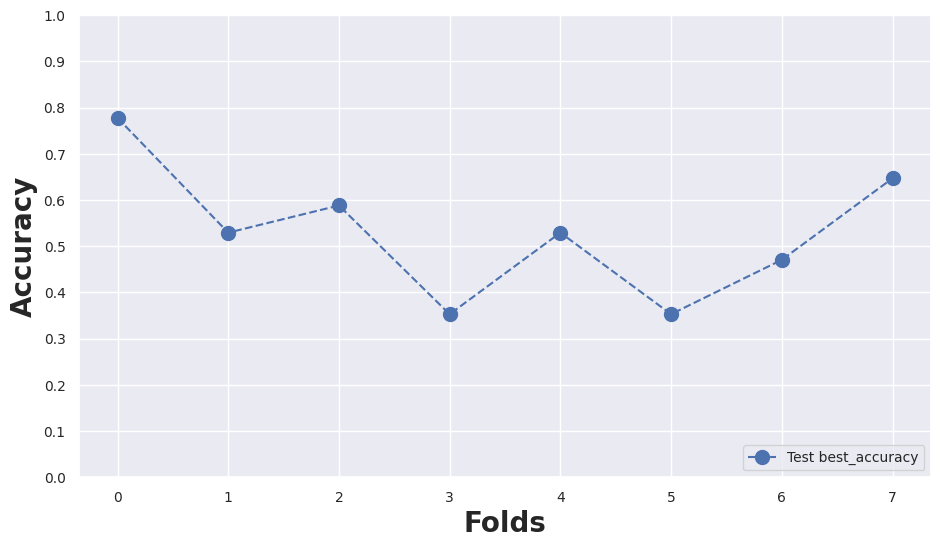

In [58]:
sns.set(rc={'figure.figsize':(11,6)})

kfold = np.arange(0,8,1)

plt.plot(kfold,scores,'--o',markersize = 10,label = 'Test best_accuracy')

plt.legend(loc = 'lower right', prop={'size': 10})
plt.xlabel('Folds',fontweight="bold",fontsize=20)
plt.ylabel('Accuracy',fontweight="bold",fontsize=20)

plt.xticks(fontsize=10)
plt.yticks(np.arange(0,1.1,0.1),fontsize=10)

plt.show()